In [1]:
import torch
import numpy as np
import torchvision
from torch.utils.data import TensorDataset, random_split
import matplotlib.pyplot as plt
import random
import math
%matplotlib inline

In [2]:
class AE(torch.nn.Module):
    def __init__(self, input_shape):
        super(AE, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_shape, 256),
            torch.nn.ReLU(True),
            torch.nn.Linear(256, 64),
            torch.nn.ReLU(True)
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(64, 256),
            torch.nn.ReLU(True),
            torch.nn.Linear(256, input_shape),
            torch.nn.Sigmoid()
        )
        
    def forward(self, features):
        code = self.encoder(features)
        reconstructed = self.decoder(code)
        return reconstructed

In [5]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform)

train_set, test_set = random_split(train_dataset, (48000, 12000))

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=128, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=10, shuffle=False)

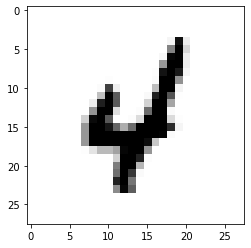

In [6]:
plt.imshow(train_set[0][0].reshape((28,28)), cmap='Greys')

In [7]:
model = AE(input_shape = 784)

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()

In [9]:
def add_noise(img):
    noise = torch.randn(img.size()) * 0.2
    noisy_img = img + noise
    noisy_img = noisy_img/torch.max(noisy_img)
    return noisy_img

In [10]:
def train(model, train_loader, optimizer, loss_fn, epochs):
    loss_list = []
    for epoch in range(epochs):
        loss = 0
        for inputs, targets in train_loader:
            #reshape inputs
            inputs = inputs.view(-1, 784)
            #add some noise
            noise_img = add_noise(inputs)
            #reser gradients
            optimizer.zero_grad()
            #compute reconstructions
            outputs = model(noise_img)
            #compute a training reconstruction loss
            train_loss = loss_fn(outputs, inputs)
            #compute accumulated gradients
            train_loss.backward()
            #update parameters based on current gradients
            optimizer.step()
            #add the batch training loss to epoch loss
            loss += train_loss.item()
        #compute the epoch training loss
        loss = loss/len(train_loader)
        loss_list.append(loss)
        #print info every 10th epoch
        if epoch%10 == 0:
            print('Epoch {} of {}, loss={:.3}'.format(epoch+1, epochs, loss))
    return loss_list

In [11]:
loss_list = train(model, test_loader, optimizer, loss_fn, 200)

Epoch 1 of 200, loss=0.0395
Epoch 11 of 200, loss=0.0101
Epoch 21 of 200, loss=0.00882
Epoch 31 of 200, loss=0.00833
Epoch 41 of 200, loss=0.00801
Epoch 51 of 200, loss=0.00776
Epoch 61 of 200, loss=0.00759
Epoch 71 of 200, loss=0.0075
Epoch 81 of 200, loss=0.00739
Epoch 91 of 200, loss=0.00727
Epoch 101 of 200, loss=0.00721
Epoch 111 of 200, loss=0.00715
Epoch 121 of 200, loss=0.0071
Epoch 131 of 200, loss=0.00704
Epoch 141 of 200, loss=0.007
Epoch 151 of 200, loss=0.00691
Epoch 161 of 200, loss=0.0069
Epoch 171 of 200, loss=0.00685
Epoch 181 of 200, loss=0.00687
Epoch 191 of 200, loss=0.00682


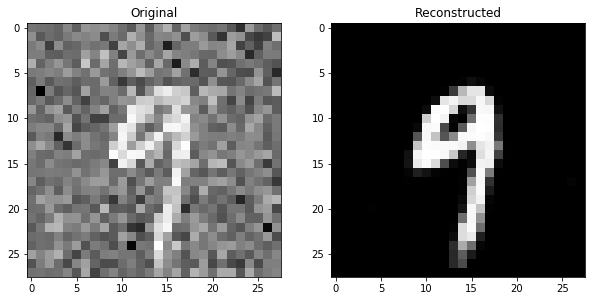

In [12]:
num = random.randint(0,len(test_set))

fig, ax = plt.subplots(1,2, figsize=(10,20))
noise_img = add_noise(train_set[num][0].view(1, 784))
out1 = model(noise_img)
out1 = out1/out1.max().item()
out1 = out1.view(28,28)
ax[0].imshow(noise_img.reshape((28,28)), cmap='Greys_r')
ax[0].set_title('Original')
ax[1].imshow(out1.detach(), cmap='Greys_r')
ax[1].set_title('Reconstructed')
plt.show()

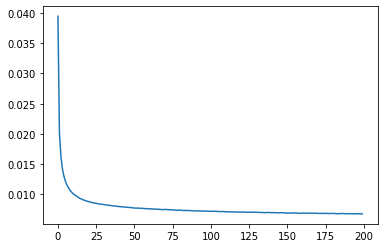

In [14]:
plt.plot(range(len(loss_list)), loss_list)

## <center> Check a batch of test set

In [55]:
from torchvision.utils import make_grid

def batch_grid(data_loader):
    for img, lab in data_loader:
        fig, ax = plt.subplots(figsize=(20,5))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(img.reshape(10,1,28,28), 10).permute(1,2,0), cmap='Greys')
        ax.set_title('Original', size=20)
        fig.savefig('Original.png', dpi=300)
        break

In [56]:
def batch_grid_grained(data_loader):
    for img, lab in data_loader:
        fig, ax = plt.subplots(figsize=(20,5))
        ax.set_xticks([]); ax.set_yticks([])
        img = add_noise(img)
        ax.imshow(make_grid(img.reshape(10,1,28,28), 10).permute(1,2,0), cmap='Greys')
        ax.set_title('With added noise', size=20)
        fig.savefig('Noised.png', dpi=300)
        break

In [57]:
def batch_grid_out(outs):
    fig, ax = plt.subplots(figsize=(20,5))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(outs.detach().reshape(10,1,28,28), 10).permute(1,2,0), cmap='Greys')
    ax.set_title('Reconstructed', size=20)
    fig.savefig('Reconstructed.png', dpi=300)

In [59]:
for img, _ in test_loader:
    img = img.view(-1, 784)
    test_out = model(img)
    test_out = test_out/test_out.max().item()
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


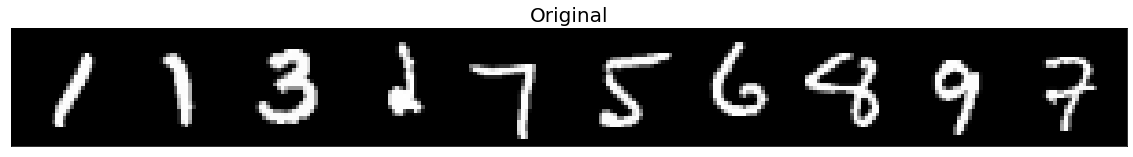

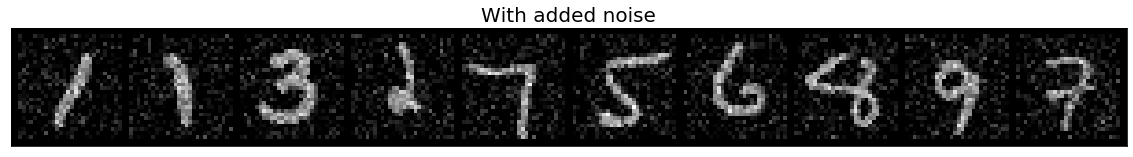

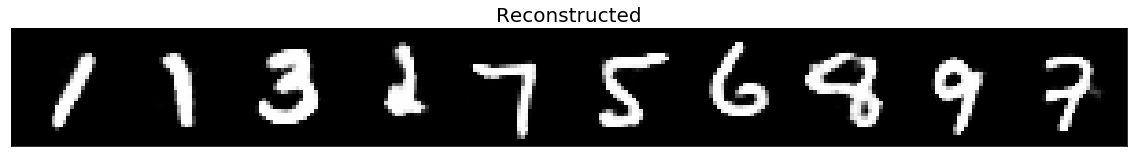

In [60]:
batch_grid(test_loader)
batch_grid_grained(test_loader)
batch_grid_out(test_out)